<div id="singlestore-header" style="display: flex; background-color: rgba(235, 249, 245, 0.25); padding: 5px;">
    <div id="icon-image" style="width: 90px; height: 90px;">
        <img width="100%" height="100%" src="https://raw.githubusercontent.com/singlestore-labs/spaces-notebooks/master/common/images/header-icons/browser.png" />
    </div>
    <div id="text" style="padding: 5px; margin-left: 10px;">
        <div id="badge" style="display: inline-block; background-color: rgba(0, 0, 0, 0.15); border-radius: 4px; padding: 4px 8px; align-items: center; margin-top: 6px; margin-bottom: -2px; font-size: 80%">SingleStore Notebooks</div>
        <h1 style="font-weight: 500; margin: 8px 0 0 4px;">IT Threat Detection, Part 3</h1>
    </div>
</div>

<div class="alert alert-block alert-info">
    <b class="fa fa-solid fa-info-circle"></b>
    <div>
        <p><b>Note</b></p>
        <p>This tutorial is meant for Standard & Premium Workspaces. You can't run this with a Free Starter Workspace due to restrictions on Storage. Create a Workspace using +group in the left nav & select Standard for this notebook. Gallery notebooks tagged with "Starter" are suitable to run on a Free Starter Workspace </p>
    </div>
</div>

## Get pipeline data from Confluent (Kafka)

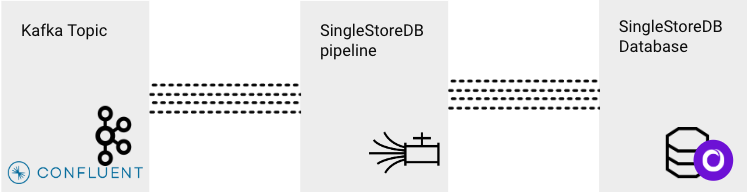

### We recommend for that step to use a S1+ size workspace

<div class="alert alert-block alert-warning">    <b class="fa fa-solid fa-exclamation-circle"></b>    <div>        <p><b>Action Required</b></p>        <p>Make sure to select the <tt>siem_log_kafka_demo</tt> database from the drop-down menu at the top of this notebook.        It updates the <tt>connection_url</tt> which is used by the <tt>%%sql</tt> magic command and SQLAlchemy to make connections to the selected database.</p>    </div></div>

In [1]:
%%sql
DROP PIPELINE IF EXISTS `siem_log_real`;
DROP TABLE IF EXISTS `siem_log_real`;

We start creating a simple table to load the logs into a JSON column

In [2]:
%%sql
CREATE TABLE IF NOT EXISTS `siem_log_real` (
  `logs` JSON COLLATE utf8_bin
  , SHARD KEY ()
) AUTOSTATS_CARDINALITY_MODE=PERIODIC AUTOSTATS_HISTOGRAM_MODE=CREATE SQL_MODE='STRICT_ALL_TABLES';

We create a pipeline from the Confluent Cluster with an interval of 20ms

In [3]:
%%sql
CREATE PIPELINE `siem_log_real`
AS LOAD DATA KAFKA 'pkc-p11xm.us-east-1.aws.confluent.cloud:9092/singlestore_topic'
CONFIG '{\"sasl.username\": \"WTIVCYPLUAIMIAYQ\",\n         \"sasl.mechanism\": \"PLAIN\",\n         \"security.protocol\": \"SASL_SSL\",\n         \"ssl.ca.location\": \"/etc/pki/ca-trust/extracted/pem/tls-ca-bundle.pem\"}'
CREDENTIALS '{"sasl.password": "/qIOhlTFEK8RNNCc1qSOnpNj4mqhXfudBlQQFgRfc0qBEjfm99VcyvEuwPILBcnv"}'
BATCH_INTERVAL 20
DISABLE OFFSETS METADATA GC
INTO TABLE `siem_log_real`
FIELDS TERMINATED BY '\t' ENCLOSED BY '' ESCAPED BY '\\'
LINES TERMINATED BY '\n' STARTING BY '';

Let's start the pipeline

In [4]:
%%sql
START PIPELINE siem_log_real;

We extract a few elements from the JSON column such as timestamp, Log_ID, and the vector to be stored in a blob format. Data is extracted as soon as an update is made to the table

In [5]:
%%sql
ALTER TABLE siem_log_real
ADD COLUMN Timestamp as JSON_EXTRACT_STRING(`logs`,'Timestamp') PERSISTED datetime,
ADD COLUMN model_res_blob AS JSON_ARRAY_PACK_F32(JSON_EXTRACT_STRING(`logs`, 'model_res')) PERSISTED BLOB,
ADD COLUMN Log_ID AS JSON_EXTRACT_BIGINT(`logs`, 'Log_ID') PERSISTED bigint;

## Install libraries for real-time dashboarding with <a href="https://github.com/finos/perspective">Perspective</a>

In [6]:
%pip install perspective-python --quiet

In [7]:
import perspective
import threading
import random
import time
from datetime import datetime, date
from perspective import Table, PerspectiveWidget
import warnings
warnings.filterwarnings('ignore')

We will set dashboard with a refresh rate of 500ms. We use two modes: stop and run to stop a dashboard retrieving results from the database.

In [8]:
def loop():
    while mode != 'stop':
        while mode == 'run':
            table.update(data_source())
            time.sleep(0.5)

## Track Real-Time Connections

In [9]:
def data_source():
    result = %sql select Timestamp, count(*) as count_connections from siem_log_real group by Timestamp order by Timestamp desc limit 100
    result2 = list(result.dicts())
    return result2

SCHEMA = {
    "Timestamp": datetime,
    "count_connections": int
}

In [10]:
mode = 'run'
table = perspective.Table(SCHEMA, limit=100)
threading.Thread(target=loop).start()

In [11]:
perspective.PerspectiveWidget(table,title = "Track Real-Time Connections", group_by=["Timestamp"],plugin="Y Line",columns=["count_connections"])

In [12]:
mode = 'stop'

## Monitor and Infer IT Threats using Semantic Search over Real-Time Data

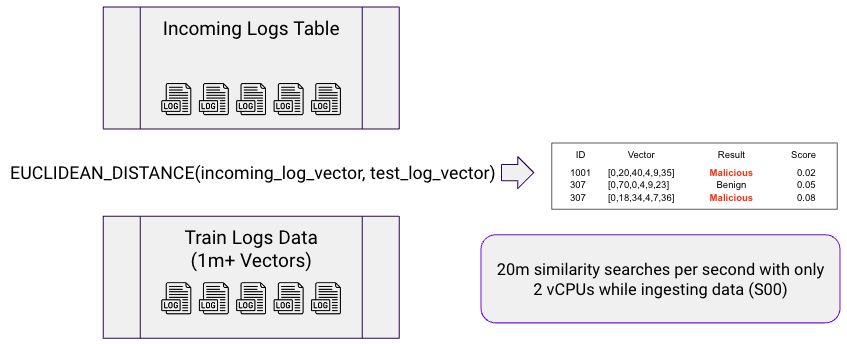

In [13]:
def data_source():
    result = %sql WITH test_sql AS (SELECT Log_ID, TIMESTAMP, id, EUCLIDEAN_DISTANCE(model_res_blob, Model_Results) AS score,ROW_NUMBER() OVER(PARTITION BY Log_ID ORDER BY EUCLIDEAN_DISTANCE(model_res_blob, Model_Results) ASC) AS rn FROM (SELECT TIMESTAMP, Log_ID, model_res_blob FROM siem_log_real ORDER BY TIMESTAMP DESC LIMIT 20) CROSS JOIN model_results where score IS NOT NULL),label_table AS (SELECT Log_ID, TIMESTAMP,MAX(CASE WHEN id LIKE 'Bru%' OR id LIKE 'SQL%' THEN 'Malicious' ELSE 'Benign' END) as log_status FROM test_sql WHERE rn <= 100 GROUP BY Log_ID,TIMESTAMP order by TIMESTAMP DESC) SELECT log_status, count(Log_ID) as count_connections FROM label_table group by log_status;
    result2 = list(result.dicts())
    return result2

SCHEMA = {
    "log_status": str,
    "count_connections": int
}

In [14]:
mode = 'run'
table = perspective.Table(SCHEMA, limit=100)
threading.Thread(target=loop).start()

In [15]:
perspective.PerspectiveWidget(table,title = "Monitor Threat Inference", split_by=["log_status"],plugin="Y Line",columns=["count_connections"])

In [16]:
mode = 'stop'

## Track latest connections with Inferences Threat Inference by Log IDs

In [17]:
def data_source():
    result = %sql WITH test_sql AS (SELECT Log_ID, TIMESTAMP, id, EUCLIDEAN_DISTANCE(model_res_blob, Model_Results) AS score,ROW_NUMBER() OVER(PARTITION BY Log_ID ORDER BY EUCLIDEAN_DISTANCE(model_res_blob, Model_Results) ASC) AS rn FROM (SELECT TIMESTAMP, Log_ID, model_res_blob FROM siem_log_real ORDER BY TIMESTAMP DESC LIMIT 20) CROSS JOIN model_results where score IS NOT NULL),label_table AS (SELECT Log_ID, TIMESTAMP,MAX(CASE WHEN id LIKE 'Bru%' OR id LIKE 'SQL%' THEN 'Malicious' ELSE 'Benign' END) as log_status FROM test_sql WHERE rn <= 100 GROUP BY Log_ID,TIMESTAMP order by TIMESTAMP DESC) SELECT * FROM label_table;
    result2 = list(result.dicts())
    return result2

SCHEMA = {
    "Log_ID": str,
    "TIMESTAMP": datetime,
    "log_status": str
}

In [18]:
mode = 'run'
table = perspective.Table(SCHEMA, limit=20)
threading.Thread(target=loop).start()

In [19]:
perspective.PerspectiveWidget(table,title = "Latest Connections", group_by=["TIMESTAMP"],plugin="Datagrid",columns=["count_attack"])

In [20]:
mode = 'stop'

<div id="singlestore-footer" style="background-color: rgba(194, 193, 199, 0.25); height:2px; margin-bottom:10px"></div>
<div><img src="https://raw.githubusercontent.com/singlestore-labs/spaces-notebooks/master/common/images/singlestore-logo-grey.png" style="padding: 0px; margin: 0px; height: 24px"/></div>